# Colour Space Experiments

In this notebook, we will be running different codes in order to test how the images of the dataset can be converted to labspace, how the class rebalancing occurs for the defined colour space above, and how we can define colour priors to best fit our data onto the colour space

### Generating Discrete Labspace Mapping

In this section we will generate the discrete 313 bins that define the labspace, more particularly the a and b components, which will map across the entire colour space. This is done by considering a 2D array of size 313x2, each having appropriate dimensions that project onto a 2D space. This array will be used further in our pipeline for training and testing of the model.

The following labspace array is obtained using existing weights available related to converting continuous colour space into discrete bins

In [5]:
# import libraries

import cv2 as cv
import numpy as np
import time
import os
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import sklearn.neighbors as nn
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
from scipy.ndimage import gaussian_filter1d


In [6]:
# load q_ab from file
q_ab = []
with open('Helper_Data/q_ab.txt', 'r') as f:
    for line in f:
        # read line and split on whitespace
        q_ab.append([int(x) for x in line.split()])
q_ab = np.array(q_ab)
print(q_ab)

# output q_ab to a file
with open('Helper_Data/q_ab.txt', 'w') as f:
    for item in q_ab:
        # write item to file with fstrings
        f.write(f"{item[0]} {item[1]}\n")


[[ -90   50]
 [ -90   60]
 [ -90   70]
 [ -90   80]
 [ -90   90]
 [ -80   20]
 [ -80   30]
 [ -80   40]
 [ -80   50]
 [ -80   60]
 [ -80   70]
 [ -80   80]
 [ -80   90]
 [ -70    0]
 [ -70   10]
 [ -70   20]
 [ -70   30]
 [ -70   40]
 [ -70   50]
 [ -70   60]
 [ -70   70]
 [ -70   80]
 [ -70   90]
 [ -60  -20]
 [ -60  -10]
 [ -60    0]
 [ -60   10]
 [ -60   20]
 [ -60   30]
 [ -60   40]
 [ -60   50]
 [ -60   60]
 [ -60   70]
 [ -60   80]
 [ -60   90]
 [ -50  -30]
 [ -50  -20]
 [ -50  -10]
 [ -50    0]
 [ -50   10]
 [ -50   20]
 [ -50   30]
 [ -50   40]
 [ -50   50]
 [ -50   60]
 [ -50   70]
 [ -50   80]
 [ -50   90]
 [ -50  100]
 [ -40  -40]
 [ -40  -30]
 [ -40  -20]
 [ -40  -10]
 [ -40    0]
 [ -40   10]
 [ -40   20]
 [ -40   30]
 [ -40   40]
 [ -40   50]
 [ -40   60]
 [ -40   70]
 [ -40   80]
 [ -40   90]
 [ -40  100]
 [ -30  -50]
 [ -30  -40]
 [ -30  -30]
 [ -30  -20]
 [ -30  -10]
 [ -30    0]
 [ -30   10]
 [ -30   20]
 [ -30   30]
 [ -30   40]
 [ -30   50]
 [ -30   60]
 [ -30   70]

### Visualization of discrete colour space 

Now that we have our colour space, we will be visualizing it based on certain sample images, to see its mapping in 2D space

In [43]:
def load_data(imagePath, size=64):
    image_folder = imagePath
    filenames = glob.glob(os.path.join(image_folder, '*.jpeg'))
    filenames = np.random.choice(filenames, size=min(100000, len(filenames)), replace=False)
    
    X_ab = np.empty((len(filenames), size, size, 2))
    
    for i, filename in enumerate(filenames):
        bgr = cv.resize(cv.imread(filename), (size, size), cv.INTER_CUBIC)
        lab = cv.cvtColor(bgr, cv.COLOR_BGR2LAB).astype(np.int32)
        X_ab[i] = lab[:, :, 1:] - 128
    
    return X_ab

def visualize_colour_space(X_ab):
    q_ab = []
    with open('Helper_Data/q_ab.txt', 'r') as f:
        for line in f:
            q_ab.append([int(x) for x in line.split()])
    q_ab = np.array(q_ab)

    plt.figure(figsize=(15, 15))
    plt.scatter(q_ab[:, 0], q_ab[:, 1])
    for i in range(q_ab.shape[0]):
        plt.text(q_ab[i, 0], q_ab[i, 1], str(i), fontsize=6)
    plt.xlim([-110, 110])
    plt.ylim([-110, 110])
    
    plt.hist2d(X_ab[..., 0].ravel(), X_ab[..., 1].ravel(), bins=100, density=True, norm=LogNorm())
    plt.xlim([-110, 110])
    plt.ylim([-110, 110])
    plt.colorbar()
    plt.show()


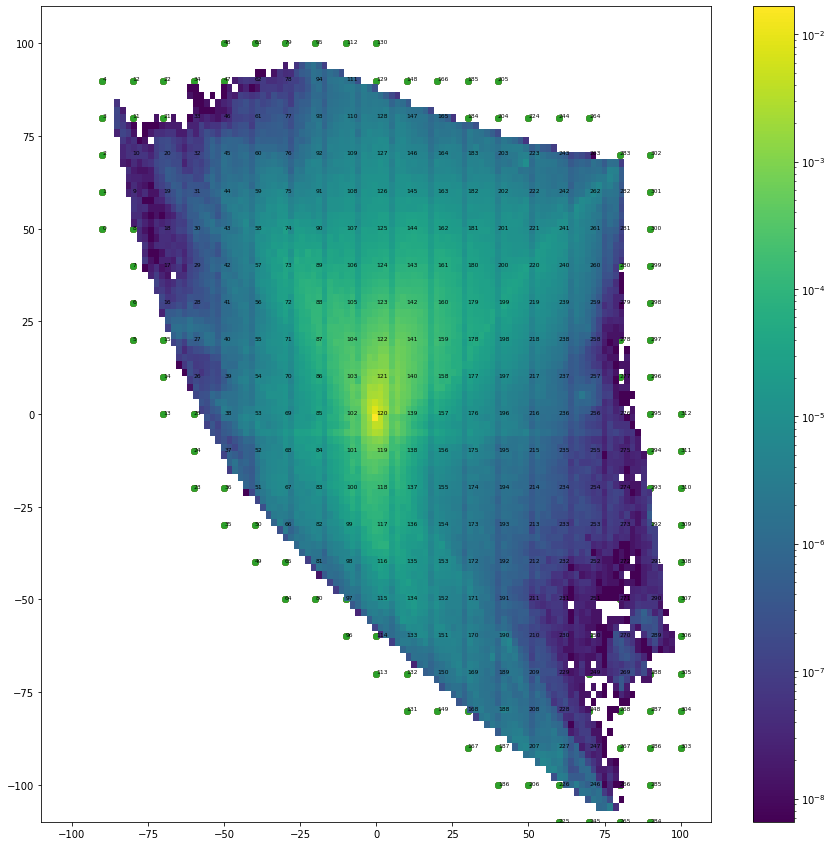

In [49]:
X_ab = load_data('../Datasets/tiny_imagenet/tiny-imagenet-200/test/images')
visualize_colour_space(X_ab)

With this colour space, we can now use the class balancing weights in the further train and testing pipeline of the code.